## 1.2 Classifier definition

Let's define a basic Classifier class. It will be used in both the normal and the adversarial training.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Load the signal/BKG DFs and split into test/train sets   

In [3]:
df_bkg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_background.csv')
df_sig = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_signal.csv')

df_sig.loc[:,'Y'] = 1
df_bkg.loc[:,'Y'] = 0



In [4]:
_df_all = pd.DataFrame()
_df_all = pd.concat([df_sig,df_bkg],sort=False)
del df_sig; del df_bkg
print (_df_all.groupby(['Y']).size())


Y
0    1512085
1     472853
dtype: int64


In [5]:
train_DF, test_DF = train_test_split(_df_all, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)
features = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL','nTop_Total_Combined', 'nJets30Clean',"Lep_relIso","Lep_miniIso","iso_pt","iso_MT2"]

S_train = train_DF[features].copy()
S_test  = test_DF[features].copy()
Y_train = train_DF['Y'].copy()
Y_test  = test_DF['Y'].copy()
Z_train = train_DF['dPhi'].copy()
Z_test  = test_DF['dPhi'].copy()

del train_DF ; del test_DF

# allocate all the dfs to the proper device 

In [6]:
S_train, S_test, Y_train, Y_test, Z_train, Z_test = [
    torch.tensor(x).to(device)
    for x in [S_train.values, S_test.values, Y_train.values, Y_test.values, Z_train.values, Z_test.values]
]

### Classifier definition


In [8]:

class Classifier(nn.Module):
    """
    Basic classifier class
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width, n_inputs=2):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x


### Adversary definition

In this simple example the adversary is a regression NN. It is used to predict the protected parameter Z from the classifier output.

In [9]:
class Regressor(nn.Module):
    """
    Basic regressor class. Can (and will) be used as the adversary in the
    training of the classifier.
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x



### Classifier training with the adversary

Train the classifier adversarially. Make sure you understand the code in this block.


Done with training


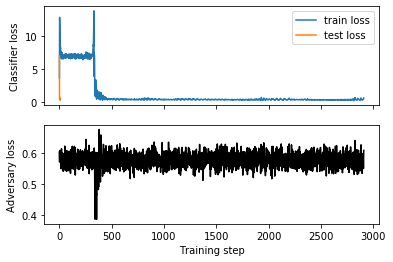

In [12]:
from tqdm import tqdm_notebook as tqdm
def adversarial_training(n_inputs,epochs=200, nbatch = 291):
    
    # create the classifier and the adversary networks
    clf = Classifier(128, n_inputs=n_inputs).to(device)
    adv = Regressor(50).to(device)

    # training settings
    learning_rate = 0.001
    lam = 10.0 # lambda tradeoff parameter

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=5*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []
    
    # training loop
    for i in tqdm(range(epochs)):
        for j in tqdm(range(nbatch)):
            # create the data
            indx = torch.randint(0, S_train.shape[0], size=(4096, ))
            #X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
            X, Y, Z = S_train[indx], Y_train[indx], Z_train[indx]
            X = torch.as_tensor(X, dtype=torch.float).to(device)
            Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float).to(device)
            Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float).to(device)

            ##############################
            # Update the adversary network
            # (several updtes to keep up with
            # the changes in the classifier)
            ##############################

            M = 5
            for _ in range(M):
                # make the adversary loss
                clf_output = clf(X)
                adv_output = adv(clf_output)
                adv_loss = adv_criterion(adv_output, Z)

                # backprop: adapt the adversary to the classifier (only update the adversary weights)
                adv.zero_grad()
                adv_loss.backward()
                adv_optimiser.step()

            adv_losses.append(adv_loss.to('cpu').detach().numpy())

            ##############################
            # Update the classifier network
            ##############################

            # forward pass
            clf_output = clf(X)
            adv_output = adv(clf_output)

            # make the losses: both the classifier and the adversary loss
            # combined loss: note the minus sign!
            # (when updating the classifier, the goal is to confuse the adversary)
            clf_loss = clf_criterion(clf_output, Y)
            adv_loss = adv_criterion(adv_output, Z)
            comb_loss = clf_loss - lam * adv_loss

            # backprop the classifier: update only the classifier weights (keep adversary intact)
            clf.zero_grad()
            comb_loss.backward()
            clf_optimiser.step()

            clf_losses.append(clf_loss.to('cpu').detach().numpy())

        #######################
        # store the test losses
        #######################
        X_t, Y_t = S_test , Y_test
        X_t = torch.as_tensor(X_t, dtype=torch.float).to(device)
        Y_t = torch.as_tensor(Y_t.reshape(-1, 1), dtype=torch.float).to(device)
        output_test = clf(X_t)
        loss_test = clf_criterion(output_test, Y_t)
        clf_losses_test.append(loss_test.to('cpu').detach().numpy())
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax[0].plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_losses)), adv_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf

clf_adv = adversarial_training(S_train.shape[1], epochs=10)
#evaluate_classifier(clf_toys_adv, generate_toys)

# Tasks for Farouk 

### what you have to do is to run over 100 epochs
1- add semilar loop to train the classifier only to be compared with the adversary <br>
2- scan range of $\lambda$ value with adverserial from $[0.5,10]$<br>
3- check few points for the same lambda and check the stability of it<br> 
4- for each batch calculate the losses of test/train sample and at the end of the epoch compare the avarage of both<br>
5- add plotting code for ROC and classifier output as well<br>
6- add code to calculate the ratios $\frac{A/B}{C/D}$<br>
7- clean up you code reqularly and keep only the lines where you need to use otherwise remove<br>